In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.replay import replay_run, replay_fig, replay_participation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
from matplotlib.ticker import AutoMinorLocator


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [9]:
session = "Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Achilles_Achilles_10252013.pkl"
with open(session, 'rb') as f:
    results = pickle.load(f)

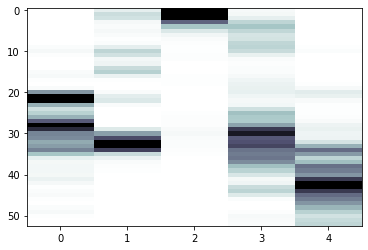

In [10]:
bst = results["outbound_epochs"]["bst_placecells"]
tc = results["outbound_epochs"]["tc"]
posterior, _, _, _ = nel.decoding.decode1D(
    bst=bst[126],
    ratemap=tc,
    xmin=tc.bins.min(),
    xmax=tc.bins.max()
)

plt.imshow(
    posterior,
    aspect="auto",
    interpolation="nearest",
    cmap="bone_r",
    vmax=0.1
)

In [5]:
from nelpy.decoding import get_mode_pth_from_array
diff_mode_pth = np.diff(get_mode_pth_from_array(posterior, tuningcurve=tc))
diff_mode_pth.mean(), diff_mode_pth.max()

(15.849056603773585, 87.54716981132074)

In [6]:
from ripple_heterogeneity.replay import score

In [7]:
(
    scores,
    avg_jump,
    scores_time_swap,
    scores_col_cycle,
    jump_col_cycle,
) = score.trajectory_score_bst(
    bst, tc, w=3, n_shuffles=250, weights=None, normalize=True
)


In [ ]:
plt.hist(jump_col_cycle[:,82],100)
plt.axvline(avg_jump[82],color="r")
plt.show()
# avg_jump.shape

In [ ]:
sig_idx, pval = functions.get_significant_events(scores,scores_time_swap)
print(sig_idx)
sig_idx, pval = functions.get_significant_events(scores,scores_col_cycle)
print(sig_idx)
sig_idx, pval = functions.get_significant_events(avg_jump,jump_col_cycle, tail="right")
print(sig_idx)

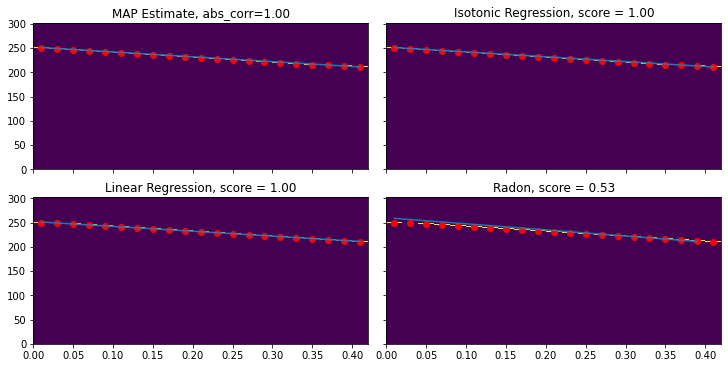

In [6]:
from scipy.stats import multivariate_normal, rv_histogram
# import replay_trajectory_classification
# from sklearn.isotonic import IsotonicRegression
# from sklearn.linear_model import LinearRegression
# from skimage.transform import radon
import numpy as np
import matplotlib.pyplot as plt
from replay_trajectory_classification.standard_decoder import (
    isotonic_regression,
    detect_line_with_radon,
    normalize_to_posterior,
    linear_regression,
    weighted_correlation,
    map_estimate
)


def test_standard_decoding(
    n_time=21,
    max_position=301,
    starting_position=250.0,
    velocity=-100,
    dt=0.020,
    dp=2.0,
    use_gaussian=False,
):

    time = np.arange(n_time) * dt
    true_replay_position = starting_position + velocity * time

    place_bin_edges = np.arange(0, max_position + dp, dp)
    place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges) / 2

    likelihood = np.zeros((time.shape[0], place_bin_centers.shape[0]))
    p_ind = np.digitize(true_replay_position, place_bin_edges.squeeze()[1:-1])
    if use_gaussian:
        for t_ind, peak in enumerate(place_bin_centers[p_ind]):
            likelihood[t_ind, :] = multivariate_normal(mean=peak, cov=144).pdf(
                place_bin_centers.squeeze()
            )
    else:
        t_ind = np.arange(len(time))
        likelihood[(t_ind, p_ind)] = 1.0

    posterior = normalize_to_posterior(likelihood)

    isotonic_prediction, isotonic_score = isotonic_regression(
        posterior, time, place_bin_centers
    )
    (
        start_position,
        estimated_velocity,
        radon_prediction,
        radon_score,
    ) = detect_line_with_radon(posterior, dt, dp)
    correlation = weighted_correlation(posterior, time, place_bin_centers)
    intercept, slope, linear_score, linear_prediction = linear_regression(
        posterior, place_bin_edges, time
    )

    time_bin_edges = np.append(time, time[-1] + dt)
    t, p = np.meshgrid(time_bin_edges, place_bin_edges)
    fig, axes = plt.subplots(
        2, 2, figsize=(10, 5), constrained_layout=True, sharex=True, sharey=True
    )
    for ax in axes.flat:
        ax.pcolormesh(t, p, likelihood.T)
        ax.scatter(time + dt / 2, true_replay_position, color="red")

    axes[0, 0].plot(time + dt / 2, map_estimate(likelihood, place_bin_centers))
    axes[0, 0].set_title(f"MAP Estimate, abs_corr={np.abs(correlation):.02f}")

    axes[0, 1].plot(time + dt / 2, isotonic_prediction)
    axes[0, 1].set_title(f"Isotonic Regression, score = {isotonic_score:.02f}")

    axes[1, 1].plot(time[:-1] + dt / 2, radon_prediction[:-1])
    axes[1, 1].set_title(f"Radon, score = {radon_score:.02f}")

    axes[1, 0].plot(time + dt / 2, linear_prediction)
    axes[1, 0].set_title(f"Linear Regression, score = {linear_score:.02f}")
test_standard_decoding()

In [43]:
start_position

78.57773428918524

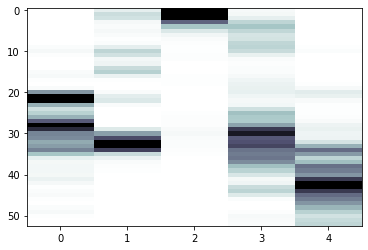

In [32]:
bst = results["outbound_epochs"]["bst_placecells"]
tc = results["outbound_epochs"]["tc"]
posterior, _, _, _ = nel.decoding.decode1D(
    bst=bst[126],
    ratemap=tc,
    xmin=tc.bins.min(),
    xmax=tc.bins.max()
)

plt.imshow(
    posterior,
    aspect="auto",
    interpolation="nearest",
    cmap="bone_r",
    vmax=0.1
)
(
    start_position,
    estimated_velocity,
    radon_prediction,
    radon_score,
) = detect_line_with_radon(posterior.T, .02, 3)

In [31]:
radon_prediction

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6.])

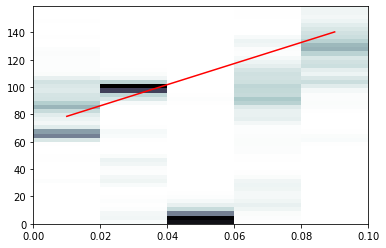

In [33]:
posterior = np.array(posterior) 
Pr = posterior

dt = .02
dp = 3
n_time = Pr.shape[1]
max_position = Pr.shape[0]*dp

time = np.arange(n_time) * dt
place_bin_edges = np.arange(0, max_position + dp, dp)
place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges) / 2

time_bin_edges = np.arange(n_time+1) * dt

t, p = np.meshgrid(time_bin_edges, place_bin_edges)

plt.pcolormesh(t, p, Pr,cmap=plt.cm.bone_r)
plt.plot(time+dt/2,radon_prediction,color='red')

In [34]:
from nelpy.analysis import replay
slope, intercept, _ = replay.linregress_array(posterior=posterior)

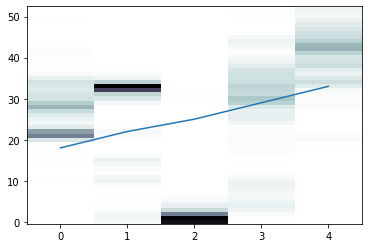

In [42]:
rows, cols = posterior.shape
x = np.arange(cols)
line_y = np.round((slope*x + intercept)) 

plt.imshow(Pr,cmap=plt.cm.bone_r,aspect='auto',origin='lower')

plt.plot(line_y)

0.2560276006150936

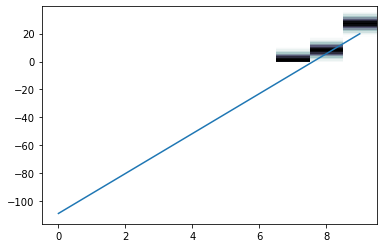

In [76]:
def make_gaussian(mu=20,sigma=3,bins=40):
    bins = np.arange(bins)
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))

Pr = np.zeros((40,10))
j=1
for i in range(10):
    if i > 6:
        Pr[:,i] = make_gaussian(mu=j**3)
        j+=1
plt.imshow(Pr,cmap=plt.cm.bone_r,aspect='auto',origin='lower',interpolation="nearest")

(
    start_position,
    estimated_velocity,
    radon_prediction,
    radon_score,
) = detect_line_with_radon(Pr.T, 1,1,filter_invalid_positions=False)

plt.plot(radon_prediction)
radon_score

In [16]:
2*3**3

54

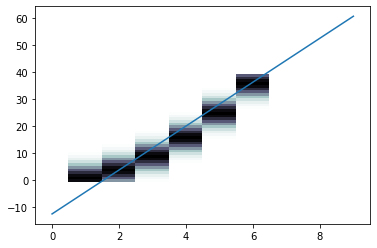

In [21]:
def make_gaussian(mu=20,sigma=3,bins=40):
    bins = np.arange(bins)
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))

Pr = np.zeros((40,10))

for i in range(1,10):
    Pr[:,i] = make_gaussian(mu=i**2)
plt.imshow(Pr,cmap=plt.cm.bone_r,aspect='auto',origin='lower',interpolation="nearest")

(
    start_position,
    estimated_velocity,
    radon_prediction,
    radon_score,
) = detect_line_with_radon(Pr.T, 1,1,filter_invalid_positions=False)

plt.plot(radon_prediction)

In [235]:
# def sub2ind(array_shape, rows, cols):
#     ind = rows*array_shape[1] + cols
#     ind[ind < 0] = -1
#     ind[ind >= array_shape[0]*array_shape[1]] = -1
#     return ind

# def sub2ind(sz, row, col):

#     ind = []
#     for rowElement, columnElement in zip(row, col):
#         ind.append(rowElement + columnElement*sz[1])

#     return ind
# def sub2ind(array_shape, rows, cols):
#     return rows*array_shape[1] + cols

def sub2ind(array_shape, rows, cols):
    ind = rows*array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    return ind

threshold = 15
circular=True
wcorr=False
jumps=False
nShuffles=500
p=0.05
matrix = Pr
nBinsY = matrix.shape[0]
nBinsX = matrix.shape[1]

x,y = np.meshgrid(np.arange(-threshold,threshold+1,1),np.arange(nBinsY))
indices = np.mod(x+y-1,nBinsY)+1

matrixID = np.zeros([1,1,matrix.shape[1]])
matrixID[:] = np.arange(matrix.shape[1])

indX = np.reshape(np.tile(indices,[1,matrix.shape[1]]),[nBinsY, threshold*2+1, matrix.shape[1]])

# ind = sub2ind(matrix.shape, indX.T, np.tile(np.array(matrixID).T,indices.shape))
# ind = sub2ind(indX, np.tile(np.array(matrixID),indices.shape),matrix.shape)
ind = sub2ind(matrix.shape, indX, np.tile(np.array(matrixID),(indX.shape[0],indX.shape[1],1)))
ind[:,:,0]
sums = np.sum(matrix[ind.astype(int)],axis=1)
# ind = np.ravel_multi_index((indX, np.tile(np.array(matrixID).T,indices.shape).astype('int')), matrix.shape, order='F')

IndexError: index 250 is out of bounds for axis 0 with size 40

In [234]:
ind[:,:,0]

array([[250., 350.,  50., ..., 260., 360.,  60.],
       [260., 360.,  60., ..., 270., 370.,  70.],
       [270., 370.,  70., ..., 280., 380.,  80.],
       ...,
       [220., 320.,  20., ..., 230., 330.,  30.],
       [230., 330.,  30., ..., 240., 340.,  40.],
       [240., 340.,  40., ..., 250., 350.,  50.]])

In [221]:
np.tile(np.array(matrixID),(indX.shape[0],indX.shape[1],1)).shape, indX.shape
# indX.shape

((40, 31, 10), (40, 31, 10))

In [191]:
arr = np.array([[3,6,6],[4,5,1]])
np.ravel_multi_index(arr, (7,6), order='F')

array([31, 41, 13], dtype=int64)

In [174]:
np.unravel_index(7, [1, 2, 3, 4], 'F')


(0, 1, 0, 1)

In [ ]:
(indX, np.tile(np.array(matrixID).T,indices.shape))

In [ ]:
[x,y]= meshgrid((-threshold:1:threshold),1:nBinsY);
indices = mod(x+y-1,nBinsY)+1;
matrixID = zeros(1,1,size(matrix,2));matrixID(:) = 1:size(matrix,2);
indX = reshape(repmat(indices,1,size(matrix,2)),[nBinsY threshold*2+1 size(matrix,2)]);
ind = sub2ind(size(matrix),indX,repmat(matrixID,size(indices)));
sums = squeeze(sum(matrix(ind),2));

In [9]:
def FindReplayScore(matrix,
                    threshold = 15,
                    circular=True,
                    wcorr=False,
                    jumps=False,
                    nShuffles=500,
                    p=0.05,
                    ):


    # # Prepare some default values
    nBinsY = matrix.shape[0]
    nBinsX = matrix.shape[1]

    # Get the matrix of sums 
    # 'sums' is the score matrix for each possible (x,y) point. 
    # The sum of the total score of a replay event would be the sum of the scores of all of its points
    # where there are (nBinsX) points, each with its preferred X orientation (among nBinsY choices), 
    # where all the points should fit on a line.
    
    x,y= np.meshgrid(np.arange(-threshold,threshold+1,1),np.arange(nBinsY))
    indices = np.mod(x+y-1,nBinsY)+1
    matrixID = np.zeros(1,1,matrix.shape[1])
    matrixID = np.arange(matrix.shape[1])
    indX = np.reshape(np.repmat(indices,1,matrix.shape[1]),[nBinsY threshold*2+1, matrix.shape[1]])
    ind = sub2ind(size(matrix),indX,np.repmat(matrixID,len(indices)))
    sums = squeeze(sum(matrix(ind),2))

    # Get magic indices describing all possible lines of the sums matrix:

    # a and b are the start and end angles (from 1 to nBins) of the linear fit
    if strcmp(circular,'on'):
        a = reshape(repmat((1:nBinsY),nBinsY*2-1,1),[],1) # the line can start anywhere
        b = repmat(-(nBinsY-1):(nBinsY-1),1,nBinsY)' + a # the line has to finish not farther than nBinsY-1 below or above a
    else:
        a = reshape(repmat((1:nBinsY),nBinsY,1),[],1) # the line can start anywhere from 1 to nBinsY
        b = reshape(repmat((1:nBinsY)',1,nBinsY),[],1) # the line can end anywhere from 1 to nBinsY
    
    # make matrix of x-elements 'x'.
    # the first column of x is a, and its last column is b
    x = [a zeros(length(a),nBinsX-2) b]
    # the middle columns go progressively from a to b
    for i=2:(nBinsX-1):
        x(:,i) = x(:,1)+(i-1)*(x(:,end)-x(:,1))/(nBinsX-1)
    
    # x is rounded so that it designates bin indices
    x = mod(round(x)-1,nBinsY)+1
    # y-coordinates
    y = repmat(1:nBinsX,size(x,1),1)
    indices = sub2ind(size(sums),x,y)

    scores = nanmean(sums(indices),2)
    [r,ind] = max(scores)
    st = a(ind) sp = b(ind)

    # if strcmp(wcorr,'on'),
        c = WeightedCorrCirc(matrix)
    # end

    # if strcmp(jumps,'on'),
        jumpShuffled = nan(nShuffles,1)
        maxJumpShuffled = nan(nShuffles,1)
        [~,goodWindows] = find(~isnan(matrix(1,:)))
        neighbour = diff(goodWindows)
        if any(neighbour==1),
            neighbour(neighbour~=1) = 0
            [~,wherePmax] = max(matrix(:,goodWindows))
            d = diff(wherePmax)
            delta = mod(d(logical(neighbour)),nBinsY)
            delta(delta>nBinsY/2) = delta(delta>nBinsY/2) - nBinsY
            maxJump = max(abs(delta))
            jump = sum(abs(delta))/length(delta)
            jumps = 'ok'
        else
            jump = nan
            maxJump = nan
        end
    # end

    # Shuffle to get a p-value

    if nShuffles>0:
        rShuffled = nan(nShuffles,1)
        cShuffled = nan(nShuffles,1)
        maxJumpShuffled = nan(nShuffles,1)
        jumpShuffled = nan(nShuffles,1)
        aShuffled = nan(nShuffles,1)
        bShuffled = nan(nShuffles,1)
        for i=1:nShuffles,
            
            shift = round(rand(1,nBinsX)*(nBinsY-1))
            mockSums = CircularShift(sums,shift)
            [rShuffled(i,1),ind] = max(mean(mockSums(indices),2))
            aShuffled(i,1) = a(ind) bShuffled(i,1) = b(ind)

    #         if strcmp(wcorr,'on'):
                mockMatrix = CircularShift(matrix,shift)
                cShuffled(i,1) = WeightedCorrCirc(mockMatrix)
            
    #         if strcmp(jumps,'ok'):
                mockMatrix = CircularShift(matrix,shift)
                [~,wherePmax] = max(mockMatrix(:,goodWindows))
                d = diff(wherePmax)
                delta = mod(d(logical(neighbour)),nBinsY)
                delta(delta>nBinsY/2) = delta(delta>nBinsY/2) - nBinsY
                maxJumpShuffled(i,1) = max(abs(delta))
                jumpShuffled(i,1) = sum(abs(delta))/length(delta)            
        
        p = sum(rShuffled>r)/nShuffles    
    

    # outputs = {r,p,st,sp,rShuffled,aShuffled,bShuffled,c,cShuffled,jump,jumpShuffled,maxJump,maxJumpShuffled}

SyntaxError: invalid syntax (4270975088.py, line 27)